In [8]:
import sqlite3

def drop_table_if_exists():
    try:
        # Conecte ao banco de dados SQLite
        conn = sqlite3.connect('db.sqlite3')
        cur = conn.cursor()

        # Apagar a tabela covid_data se ela existir
        cur.execute("DROP TABLE IF EXISTS covid_data")
        conn.commit()
        
        cur.close()
        conn.close()
        print("Tabela covid_data apagada com sucesso")

    except Exception as e:
        print(f"Erro ao apagar a tabela covid_data: {e}")

# Chame a função para apagar a tabela
drop_table_if_exists()


Tabela covid_data apagada com sucesso


In [9]:
import sqlite3
import csv
import logging
import os

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def clean_value(value):
    if value == '':
        return None
    return value

def fill_and_concat_city_state(reader):
    previous_city = None
    filled_rows = []
    for row in reader:
        if row[1]:
            previous_city = row[1]
        else:
            row[1] = f"{previous_city} - {row[16]}"
        filled_rows.append(row)
    return filled_rows

def load_csv_to_sqlite(csv_file_path):
    try:
        # Conecte ao banco de dados SQLite
        conn = sqlite3.connect('db.sqlite3')
        cur = conn.cursor()

        # Crie a tabela
        cur.execute("""
        CREATE TABLE IF NOT EXISTS covid_data (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            city TEXT,
            city_ibge_code FLOAT,
            date DATE,
            epidemiological_week INT,
            estimated_population FLOAT,
            estimated_population_2019 FLOAT,
            is_last BOOLEAN,
            is_repeated BOOLEAN,
            last_available_confirmed INT,
            last_available_confirmed_per_100k_inhabitants FLOAT,
            last_available_date DATE,
            last_available_death_rate FLOAT,
            last_available_deaths INT,
            order_for_place INT,
            place_type TEXT,
            state TEXT,
            new_confirmed INT,
            new_deaths INT,
            daily_variation FLOAT
        )
        """)
        conn.commit()

        # Carregar o arquivo CSV com a codificação correta
        with open(csv_file_path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)  # Pular o cabeçalho
            filled_rows = fill_and_concat_city_state(reader)

            # Processar e carregar os dados
            for row in filled_rows:
                # Ignorar a primeira coluna "Unnamed: 0" e limpar valores
                cleaned_row = [clean_value(val) for val in row[1:]]
                cur.execute("""
                    INSERT INTO covid_data (
                        city, city_ibge_code, date, epidemiological_week,
                        estimated_population, estimated_population_2019, is_last,
                        is_repeated, last_available_confirmed,
                        last_available_confirmed_per_100k_inhabitants, last_available_date,
                        last_available_death_rate, last_available_deaths,
                        order_for_place, place_type, state, new_confirmed,
                        new_deaths, daily_variation
                    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                """, cleaned_row)
        conn.commit()
        cur.close()
        conn.close()
        logger.info("CSV loaded into SQLite successfully")

    except Exception as e:
        logger.error(f"Error loading CSV to SQLite: {e}")

# Defina o caminho do arquivo CSV diretamente
# csv_file_path = '../Dataset-2/file-minimal-data.csv'
csv_file_path = '../Dataset-2/file.csv'
load_csv_to_sqlite(csv_file_path)


INFO:__main__:CSV loaded into SQLite successfully


O código fornecido não atende aos requisitos totalmente, pois ele considera apenas a variação máxima diária por cidade e não calcula o ranking das 20 maiores variações diárias de novos casos. Além disso, a função read_excel está escrita incorretamente como read_excell.

In [ ]:
# code.ipynb
# import pandas as pd

# dados = pd.read_excell('file.xls')

# # Converter a coluna 'date' para o tipo datetime
# dados['date'] = pd.to_datetime(dados['date'])

# # Calcular a variação diária do número de casos por cidade
# dados['variação_diária'] = dados.groupby('city')['new_confirmed'].diff()

# # Filtrar os dados para remover as variações negativas (caso haja)
# dados = dados[dados['variação_diária'] >= 0]

# # Agrupar os dados por cidade e calcular a variação máxima
# variação_maxima_por_cidade = dados.groupby('city')['variação_diária'].max().reset_index()

# # Ordenar as cidades com base na variação máxima em ordem decrescente
# ranking_cidades = variação_maxima_por_cidade.sort_values(by='variação_diária', ascending=False)

# # Criar o DataFrame final com as três colunas requeridas
# ranking_final = ranking_cidades.head(10)  

# # Exibir o resultado
# print(ranking_final)

# Questão 11: Ranking das 20 Maiores Variações Diárias de Novos Casos de Covid

In [13]:
import sqlite3
import pandas as pd

# Conecte ao banco de dados SQLite
conn = sqlite3.connect('db.sqlite3')

# Define o tamanho dos chunks para leitura incremental
chunksize = 100000

# Função para processar os dados em chunks
def process_chunks():
    chunks = pd.read_sql_query("SELECT * FROM covid_data", conn, chunksize=chunksize)
    
    # Lista para armazenar todos os chunks processados
    processed_chunks = []
    
    for chunk in chunks:
        # Converter a coluna 'date' para o tipo datetime
        chunk['date'] = pd.to_datetime(chunk['date'])
        
        # Calcular a variação diária do número de casos por cidade
        chunk['variação_diária'] = chunk.groupby('city')['new_confirmed'].diff()
        
        # Filtrar os dados para remover as variações negativas (caso haja)
        chunk = chunk[chunk['variação_diária'] >= 0]
        
        # Adicionar o chunk processado à lista
        processed_chunks.append(chunk)
    
    # Concatenar todos os chunks processados
    return pd.concat(processed_chunks)

# Processar os dados em chunks
dados = process_chunks()

# Ordenar os dados com base na variação diária em ordem decrescente
dados_ordenados = dados.sort_values(by='variação_diária', ascending=False)

# Selecionar as 20 maiores variações diárias
top_20_variações = dados_ordenados.head(20)

# Agrupar por data e listar as cidades distintas para cada data com as maiores variações
ranking_final = top_20_variações.groupby('date').agg({
    'city': lambda x: list(x.unique()),
    'variação_diária': 'max'
}).reset_index()

# Ordenar novamente para garantir a ordem decrescente pelas variações diárias
ranking_final = ranking_final.sort_values(by='variação_diária', ascending=False).head(20)

# Exibir o resultado
print(ranking_final)

# Fechar a conexão com o banco de dados
conn.close()


         date                            city  variação_diária
13 2021-11-22  [Nísia Floresta, Passa e Fica]          59430.0
2  2020-10-12                [Nísia Floresta]          59429.0
11 2021-09-03    [Belo Horizonte, Uberlândia]          43091.0
15 2022-01-19                         [Natal]          43037.0
14 2021-11-23    [Natal, Mossoró, Parnamirim]          42169.0
6  2021-03-07                      [Curitiba]          40081.0
1  2020-09-17        [Santa Margarida do Sul]          23275.0
7  2021-04-04        [Santa Margarida do Sul]          23275.0
3  2020-11-18                   [Santa Maria]          22885.0
8  2021-04-05                   [Santa Maria]          22823.0
12 2021-10-02                [Rio de Janeiro]          22719.0
9  2021-04-21                [Belo Horizonte]          19659.0
5  2021-01-04                  [Passa e Fica]          19209.0
4  2020-11-20                        [Cuiabá]          19020.0
10 2021-06-22                         [Natal]          

In [16]:
!pip install seaborn

DEPRECATION: Loading egg at c:\users\erick bryan\appdata\local\programs\python\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


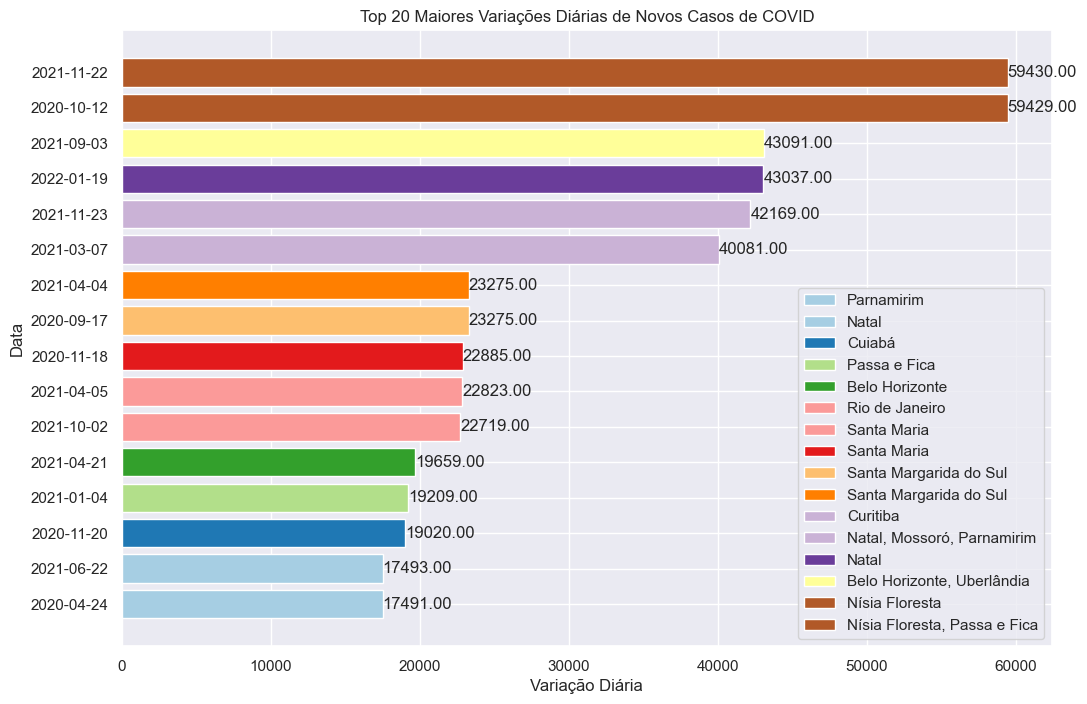

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

# Certifique-se de que os dados estejam ordenados corretamente para o gráfico
ranking_final = ranking_final.sort_values(by='variação_diária', ascending=True)

# Configurar o estilo do gráfico
sns.set(style='darkgrid')

# Criar o gráfico de colunas horizontal
fig, ax = plt.subplots(figsize=(12, 8))

# Definir as cores para as barras
colors = cm.Paired(np.linspace(0, 1, len(ranking_final)))

# Criar as barras horizontais
bars = ax.barh(ranking_final['date'].astype(str), ranking_final['variação_diária'], color=colors)

# Adicionar os valores das variações diárias na frente das colunas
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

# Adicionar as legendas
legend_labels = [', '.join(city_list) for city_list in ranking_final['city']]
for bar, label in zip(bars, legend_labels):
    bar.set_label(label)

ax.legend()

# Títulos e rótulos
ax.set_title('Top 20 Maiores Variações Diárias de Novos Casos de COVID')
ax.set_xlabel('Variação Diária')
ax.set_ylabel('Data')

# Exibir o gráfico
plt.show()


# Questão 12: Análise Exploratória de Dados de Covid

In [1]:
import sqlite3
import pandas as pd

# Conectar ao banco de dados SQLite
conn = sqlite3.connect('db.sqlite3')

# Carregar os dados da tabela covid_data no DataFrame pandas
query = "SELECT * FROM covid_data"
dados_covid = pd.read_sql_query(query, conn)

# Fechar a conexão com o banco de dados
conn.close()

# Exibir as primeiras linhas do DataFrame para verificar o conteúdo
dados_covid.head()


,id,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths,daily_variation
0,1,Rio Branco,1200401.0,2020-03-17,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-17,0.0,0,1,city,AC,3,0,NaN
1,2,Rio Branco - AC,12.0,2020-03-17,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-17,0.0,0,1,state,AC,3,0,NaN
2,3,Rio Branco,1200401.0,2020-03-18,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-18,0.0,0,2,city,AC,0,0,-3.0
3,4,Rio Branco - AC,12.0,2020-03-18,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-18,0.0,0,2,state,AC,0,0,NaN
4,5,Rio Branco,1200401.0,2020-03-19,202012,413418.0,407319.0,False,False,4,0.96754,2020-03-19,0.0,0,3,city,AC,1,0,1.0


In [12]:
# Definir o agrupamento de estados por região
regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['GO', 'MT', 'MS', 'DF'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

# Mapear os estados para suas respectivas regiões
def obter_regiao(estado):
    for regiao, estados in regioes.items():
        if estado in estados:
            return regiao
    return 'Desconhecido'

dados_covid['regiao'] = dados_covid['state'].apply(obter_regiao)


### Análise Exploratória Inicial (EDA)

In [3]:
print("Informações sobre o DataFrame: \n")
dados_covid.info()
print("Estátisticas descritivas do DataFrame: \n")
dados_covid.describe()
print("Valores nulos por coluna: \n")
dados_covid.isnull().sum()


Informações sobre o DataFrame: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3853648 entries, 0 to 3853647
Data columns (total 20 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   id                                             int64  
 1   city                                           object 
 2   city_ibge_code                                 float64
 3   date                                           object 
 4   epidemiological_week                           int64  
 5   estimated_population                           float64
 6   estimated_population_2019                      float64
 7   is_last                                        object 
 8   is_repeated                                    object 
 9   last_available_confirmed                       int64  
 10  last_available_confirmed_per_100k_inhabitants  float64
 11  last_available_date                            object 
 12  last_avai

id                                                   0
city                                                 0
city_ibge_code                                   13646
date                                                 0
epidemiological_week                                 0
estimated_population                             13646
estimated_population_2019                        13646
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants    29166
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths

### Gráficos Representativos

In [14]:
# Amostrar 1% dos dados aleatoriamente
dados_amostra = dados_covid.sample(frac=0.01, random_state=1)

# Converter a coluna 'date' para o tipo datetime
dados_amostra['date'] = pd.to_datetime(dados_amostra['date'])


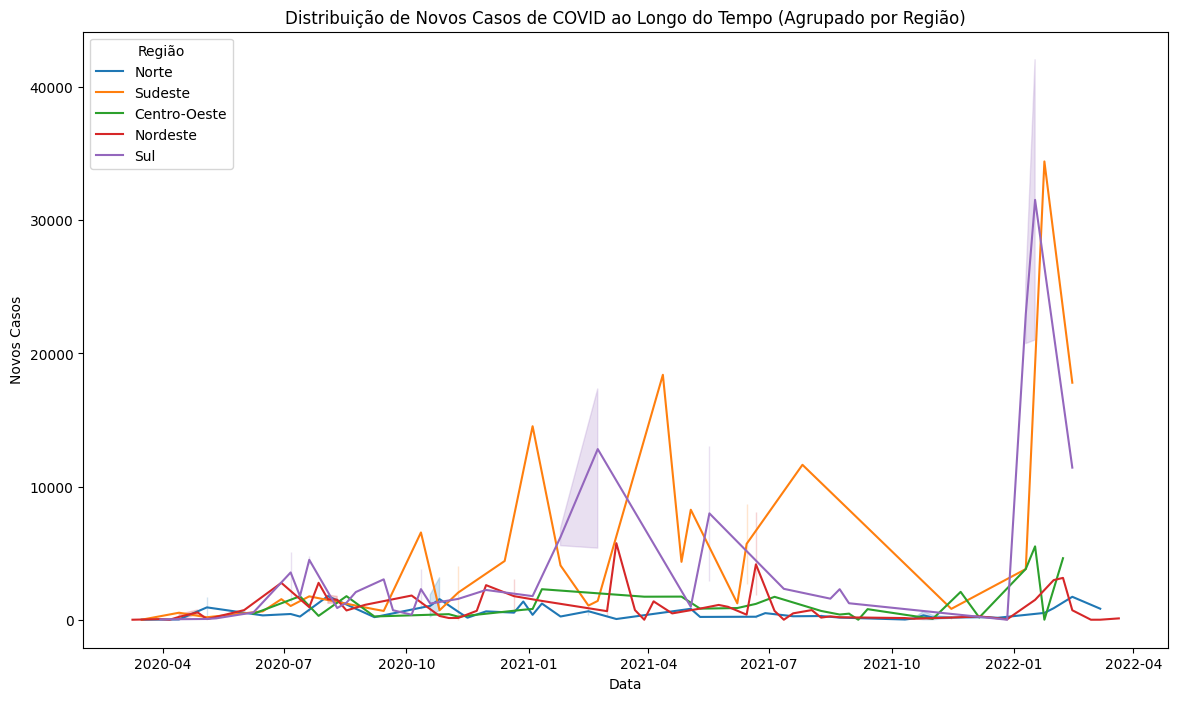

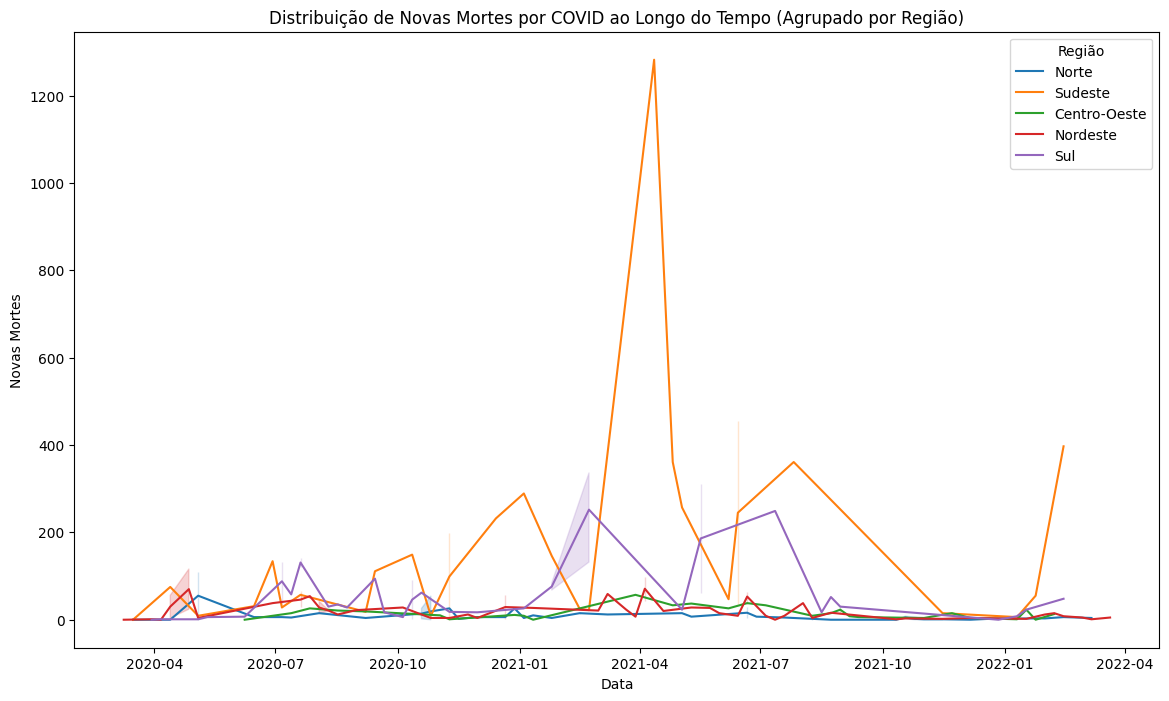

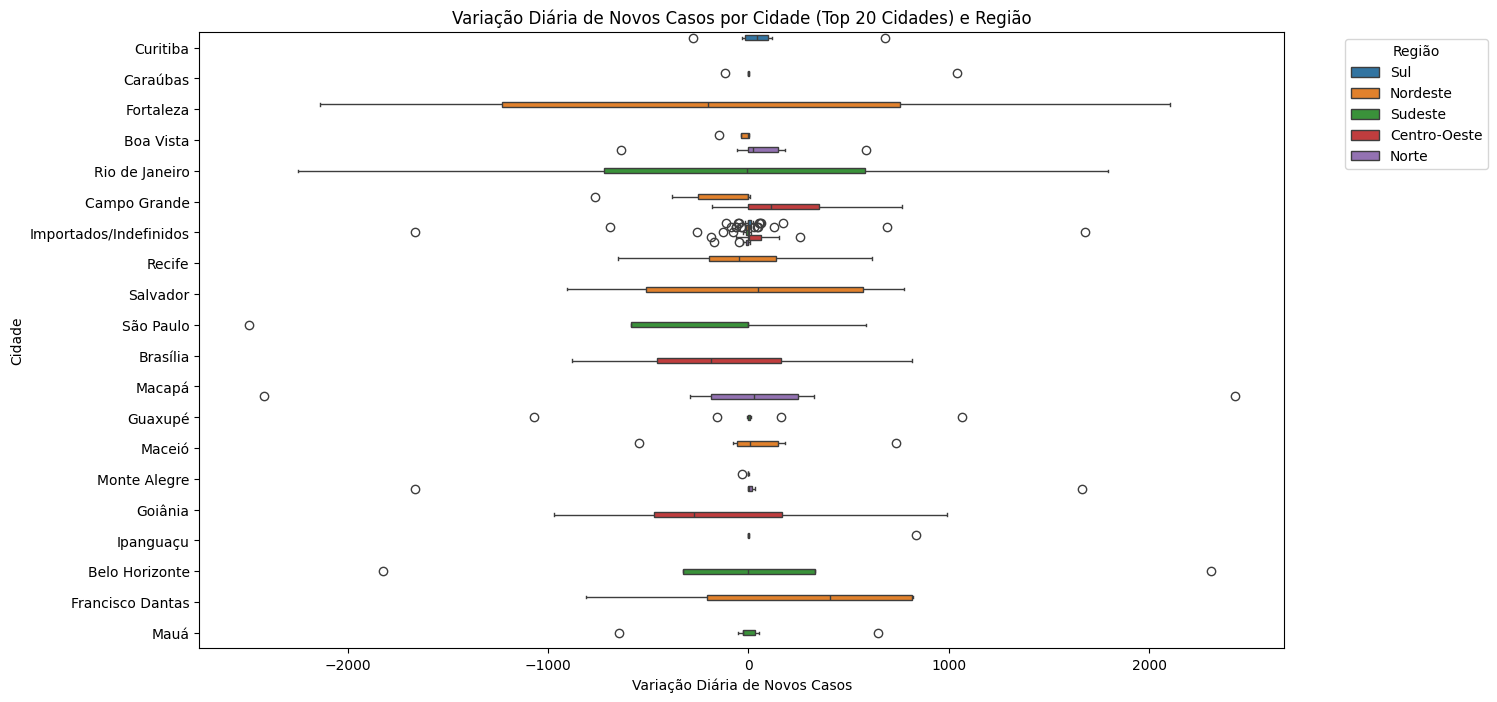

C:\Users\Erick Bryan\AppData\Local\Temp\ipykernel_28048\1233566757.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_amostra_estados['death_rate'] = dados_amostra_estados['last_available_deaths'] / dados_amostra_estados['last_available_confirmed']
C:\Users\Erick Bryan\AppData\Local\Temp\ipykernel_28048\1233566757.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=taxa_mortalidade_regiao, x='regiao', y='death_rate', ci=None)


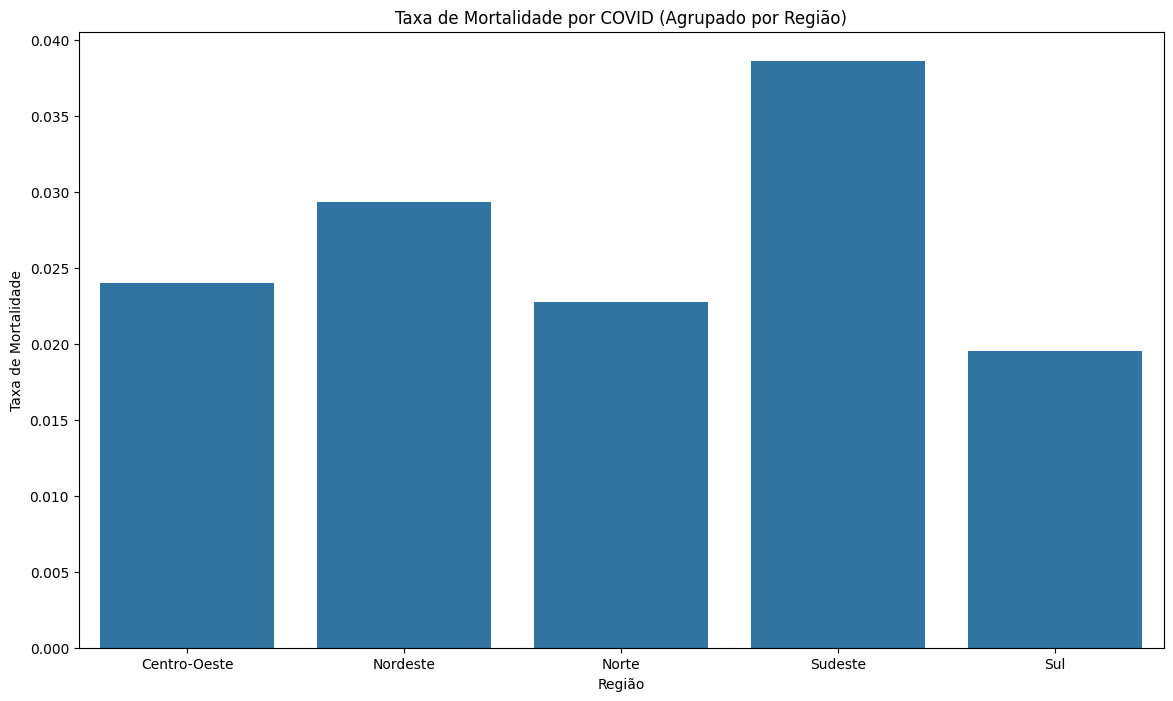

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar os dados por semana para suavizar as flutuações diárias
dados_amostra['week'] = dados_amostra['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Filtra apenas os estados
dados_amostra_estados = dados_amostra[dados_amostra['place_type'] == 'state']

# 1. Distribuição de novos casos ao longo do tempo, agrupado por região
plt.figure(figsize=(14, 8))
sns.lineplot(data=dados_amostra_estados, x='week', y='new_confirmed', hue='regiao', estimator='sum')
plt.title('Distribuição de Novos Casos de COVID ao Longo do Tempo (Agrupado por Região)')
plt.xlabel('Data')
plt.ylabel('Novos Casos')
plt.legend(title='Região')
plt.show()

# 2. Distribuição de novas mortes ao longo do tempo, agrupado por região
plt.figure(figsize=(14, 8))
sns.lineplot(data=dados_amostra_estados, x='week', y='new_deaths', hue='regiao', estimator='sum')
plt.title('Distribuição de Novas Mortes por COVID ao Longo do Tempo (Agrupado por Região)')
plt.xlabel('Data')
plt.ylabel('Novas Mortes')
plt.legend(title='Região')
plt.show()

# Calcular a variação diária de novos casos
dados_amostra['variação_diária'] = dados_amostra.groupby('city')['new_confirmed'].diff()

# Filtrar os dados_amostra para incluir apenas cidades (place_type = city)
dados_amostra_cidades = dados_amostra[dados_amostra['place_type'] == 'city']

# Selecionar as 20 cidades com as maiores variações diárias absolutas
top_cidades = dados_amostra_cidades.groupby('city')['variação_diária'].max().abs().nlargest(20).index

# Filtrar os dados para essas cidades
dados_top_cidades = dados_amostra_cidades[dados_amostra_cidades['city'].isin(top_cidades)]

# 3. Boxplot da variação diária de novos casos por cidade, agrupado por região
plt.figure(figsize=(14, 8))
sns.boxplot(data=dados_top_cidades, x='variação_diária', y='city', hue='regiao')
plt.title('Variação Diária de Novos Casos por Cidade (Top 20 Cidades) e Região')
plt.xlabel('Variação Diária de Novos Casos')
plt.ylabel('Cidade')
plt.legend(title='Região', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Calcular a taxa de mortalidade
dados_amostra_estados['death_rate'] = dados_amostra_estados['last_available_deaths'] / dados_amostra_estados['last_available_confirmed']

# Agrupar por região e calcular a média da taxa de mortalidade
taxa_mortalidade_regiao = dados_amostra_estados.groupby('regiao')['death_rate'].mean().reset_index()

# 4. Taxa de mortalidade ao longo do tempo, agrupado por região
plt.figure(figsize=(14, 8))
sns.barplot(data=taxa_mortalidade_regiao, x='regiao', y='death_rate', ci=None)
plt.title('Taxa de Mortalidade por COVID (Agrupado por Região)')
plt.xlabel('Região')
plt.ylabel('Taxa de Mortalidade')
plt.show()




# Questão 13: Minimizar Erros de Anotação em Projetos de Visão Computacional
Para minimizar possíveis erros de anotações em um projeto de visão computacional focado em segmentações específicas, como para-brisas de automóveis, você pode implementar várias estratégias:

1. **Padronização de Anotações**:
   - **Definir Diretrizes Claras**: Estabelecer regras detalhadas e padronizadas para a anotação de imagens [<sup>1</sup>*](https://pt.shaip.com/in-the-media/the-most-prominent-image-annotation-techniques-and-their-use-cases/). Isso inclui instruções específicas sobre como segmentar as áreas de interesse (como para-brisas) e critérios para resolver ambiguidades [<sup>2</sup>*](https://www.dagshub.com/blog/common-pitfalls-in-computer-vision-projects/).
   - **Treinamento de Anotadores**: Treinar anotadores para garantir que compreendam plenamente as diretrizes e a importância da precisão. Sessões de treinamento e exemplos anotados podem ajudar a alinhar o entendimento entre todos os anotadores [<sup>3</sup>*](https://www.deepchecks.com/blog/common-pitfalls-when-building-a-computer-vision-model/).

2. **Revisão e Validação**:
   - **Revisão por Pares**: Implementar um sistema de revisão por pares onde as anotações feitas por um anotador são revisadas por outro para identificar e corrigir erros [<sup>4</sup>*](https://viso.ai/computer-vision/why-computer-vision-projects-fail/).
   - **Auditorias Regulares**: Realizar auditorias regulares das anotações para garantir a consistência e a precisão ao longo do tempo [<sup>2</sup>*](https://www.dagshub.com/blog/common-pitfalls-in-computer-vision-projects/).

3. **Uso de Ferramentas Automatizadas**:
   - **Ferramentas de Anotação Assistida por IA**: Utilizar ferramentas de anotação que aproveitam algoritmos de IA para sugerir anotações, que depois podem ser ajustadas e validadas pelos anotadores humanos. Isso pode aumentar a eficiência e reduzir a probabilidade de erros [<sup>1</sup>*](https://pt.shaip.com/in-the-media/the-most-prominent-image-annotation-techniques-and-their-use-cases/) [<sup>5</sup>*](https://www.infopulse.com/blog/5-challenges-of-implementing-computer-vision/).

4. **Feedback Contínuo**:
   - **Ciclo de Feedback**: Implementar um ciclo de feedback contínuo onde os anotadores recebem informações sobre a precisão e a qualidade de suas anotações. Isso ajuda a melhorar suas habilidades e a identificar áreas problemáticas [<sup>3</sup>*](https://www.deepchecks.com/blog/common-pitfalls-when-building-a-computer-vision-model/).

5. **Validação de Dados**:
   - **Verificação de Coerência**: Utilizar técnicas de verificação de coerência para assegurar que as anotações são consistentes entre diferentes imagens e anotadores. Algoritmos podem ser aplicados para verificar discrepâncias e inconsistências [<sup>2</sup>*](https://www.dagshub.com/blog/common-pitfalls-in-computer-vision-projects/) [<sup>4</sup>*](https://viso.ai/computer-vision/why-computer-vision-projects-fail/).

Ao aplicar essas estratégias, você pode aumentar a precisão e a qualidade das anotações de imagem, assegurando que os modelos de deep learning treinados com esses dados tenham um desempenho superior em suas tarefas [<sup>1</sup>*](https://pt.shaip.com/in-the-media/the-most-prominent-image-annotation-techniques-and-their-use-cases/) [<sup>2</sup>*](https://www.dagshub.com/blog/common-pitfalls-in-computer-vision-projects/) [<sup>3</sup>*](https://www.deepchecks.com/blog/common-pitfalls-when-building-a-computer-vision-model/) [<sup>4</sup>*](https://viso.ai/computer-vision/why-computer-vision-projects-fail/) [<sup>5</sup>*](https://www.infopulse.com/blog/5-challenges-of-implementing-computer-vision/).

## Referências
1. [The Most Prominent Image Annotation Techniques and Their Use Cases](https://pt.shaip.com/in-the-media/the-most-prominent-image-annotation-techniques-and-their-use-cases/)
2. [Common Pitfalls in Computer Vision Projects](https://www.dagshub.com/blog/common-pitfalls-in-computer-vision-projects/)
3. [Common Pitfalls When Building a Computer Vision Model](https://www.deepchecks.com/blog/common-pitfalls-when-building-a-computer-vision-model/)
4. [Why Computer Vision Projects Fail](https://viso.ai/computer-vision/why-computer-vision-projects-fail/)
5. [5 Challenges of Implementing Computer Vision](https://www.infopulse.com/blog/5-challenges-of-implementing-computer-vision/)